In [2]:
import numpy as np
from geomstats.geometry.manifold import Manifold
from geomstats.geometry.riemannian_metric import RiemannianMetric
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric
from numpy.random import random
from sasaki_metric import SasakiMetric
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.grassmannian import Grassmannian
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.euclidean import  Euclidean
#import geomstats.datasets.utils as data_utils
import geomstats.backend as gs
from util import visSphere, visKen, load_data
import geomstats.visualization as visualization
import logging
from IPython.display import Image

Nt = 25
t = np.linspace(0, 1, Nt)

First Application: Shortest paths and mean of geodesics on the 2-Sphere

In [3]:
S2 = Hypersphere(dim=2)
S2_metric = S2.metric
sas = SasakiMetric(S2_metric, S2.shape, 4)

Compute the shortest path

INFO: reached tolerance 1e-06
INFO: iterations: 0
INFO: |grad|: 1.7180188261322608e-15


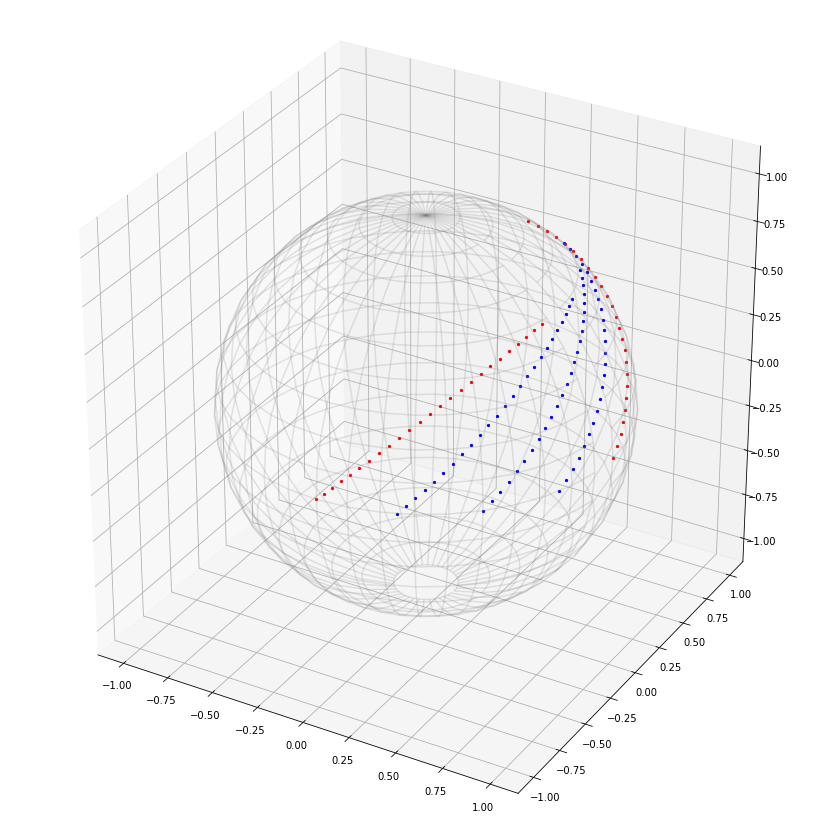

In [4]:
p0, u0 = np.array([0, -1, 0]), np.array([1, 0, 1])
pu0 = np.array([p0, u0])
pL, uL = np.array([1, 0, 0]), np.array([0, 1, 1])
puL = np.array([pL, uL])
z = sas.geodesic(pu0, puL)
geo_list, color_list = [], []
geods0L, geods = [], []
for i in range(Nt):
    geods0L.append(S2_metric.exp(t[i] * u0, p0))
    geods0L.append(S2_metric.exp(t[i] * uL, pL))
geo_list = [geods0L]
color_list.append('r')
for j in range(1, len(z) - 1):
    p1, u1 = z[j][0], z[j][1]
    for i in range(Nt):
        geods.append(S2_metric.exp(t[i] * u1, p1))
geo_list += [geods]
color_list += 'b'
visSphere(geo_list, color_list, 15)

Compute mean

INFO: reached tolerance 1e-06
INFO: iterations: 0
INFO: |grad|: 0.0


Computing mean of geodesics


INFO: reached tolerance 1e-06
INFO: iterations: 26
INFO: |grad|: 7.490082223863008e-07


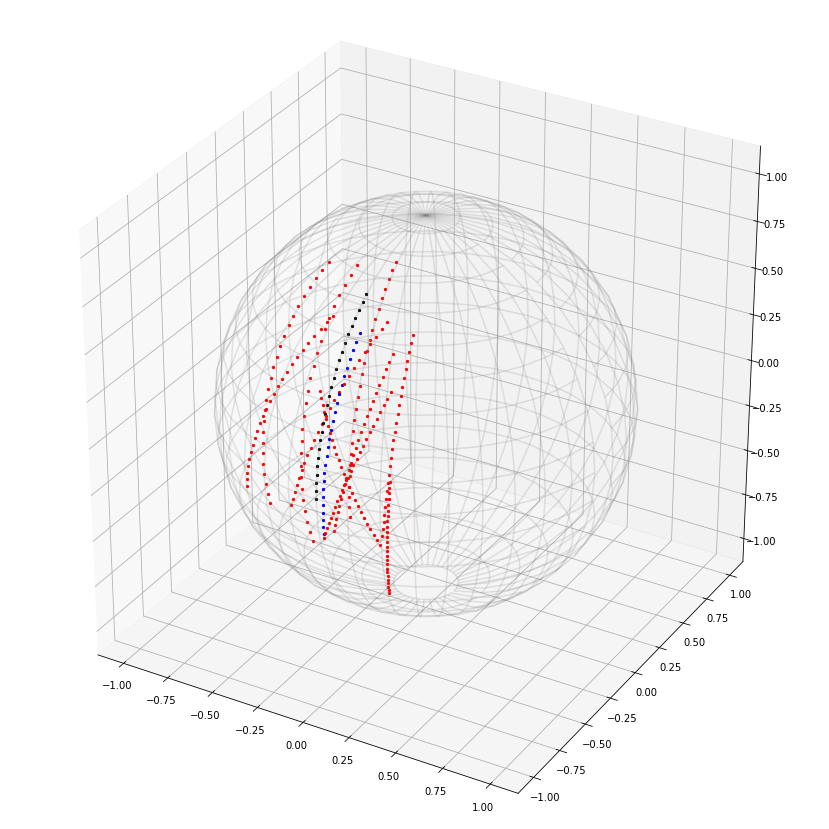

In [5]:
m = np.array([[0, -1, 0], [0, 0, 1]])
n_samples, sigma = 10, np.pi/12
x = S2.random_riemannian_normal(m[0], n_samples=n_samples)
y = S2.random_riemannian_normal(m[0], n_samples=n_samples)
x = [S2_metric.exp(sigma*S2_metric.log(x[i], m[0]), m[0]) for i in range(n_samples)]
u = [m[1] + sigma*S2_metric.log(y[i], m[0]) for i in range(n_samples)]
samples = [np.array([x[i], u[i]]) for i in range(n_samples)]
print('Computing mean of geodesics')
#mean = sm.mean(z)
#gg=Grassmannian(5,2)
#mean_gs = FrechetMean(S2_metric)
#mean_gs.fit(samples)
#mean_estimate = mean_gs.estimate_
mean = sas.mean(samples)
#mp, mu = mean[0], mean[1]
meanvalue, data, geom = [], [], []
for i in range(Nt):
    ti = t[i]
    meanvalue.append(S2_metric.exp(ti * m[1], m[0]))
    geom.append(S2_metric.exp(ti * mean[1], mean[0]))
    for j in range(len(samples)):
        data.append(S2_metric.exp(ti * samples[j][1], samples[j][0]))
geo_list = [meanvalue] + [data] + [geom]
color_list = ['k'] + ['r'] + ['b']
visSphere(geo_list, color_list, 15)

Third application: Discrete Geodesics and Mean Geodesic in Kendall's Shape Space

![rat](ratyz.png)

Total number of rat skulls: 144


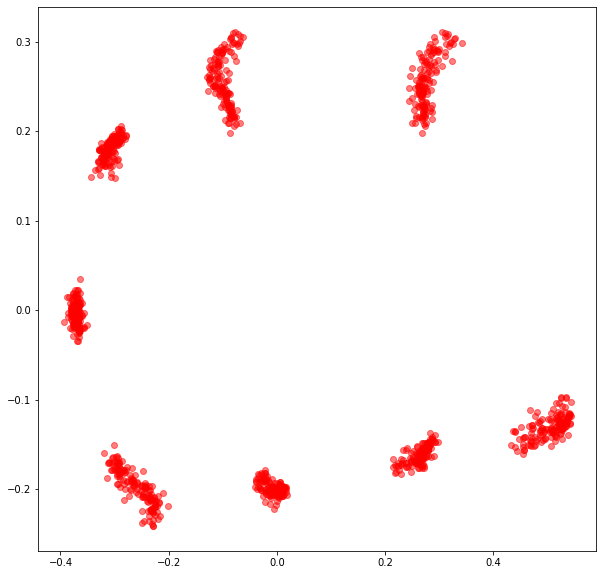

In [6]:
KenMetric = KendallShapeMetric(8, 2)
Ken = PreShapeSpace(8, 2)
sas = SasakiMetric(KenMetric, Ken.shape)
samples = load_data()
print(f"Total number of rat skulls: {len(samples)}")
samples = [Ken.projection(samples[i]) for i in range(144)]
visKen([samples], ['r'])
# Regression
# TPCA
# Learnin